# Importing packages

In [48]:
from time import sleep
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from linkedin_scraper import  actions
from bs4 import BeautifulSoup
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
import re
from selenium.webdriver import ActionChains

In [49]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


#  Connecting to linkedin

In [3]:
service = Service('/Users/brahamyoussef/Desktop/chromedriver')
service.start()
driver = webdriver.Remote(service.service_url)
email = "brahamyoussef2@gmail.com"
password = "you_can_try_to_guess"
actions.login(driver, email, password) # if email and password isnt given, it'll prompt in terminal

#  Scrolling to the bottom of the followed companies pages

In [4]:
companies_followed = "https://www.linkedin.com/in/youssefbraham/details/interests/?detailScreenTabIndex=1"
driver.get(companies_followed)

start = time.time()
initialScroll = 0
finalScroll = 1000
while True:
    driver.execute_script(f"window.scrollTo({initialScroll},{finalScroll})")
    initialScroll = finalScroll
    finalScroll += 1000
    time.sleep(2)
    end = time.time()
    if round(end - start) > 500:
        break

# Extracting the companies names and links to a dictionnary

In [5]:
src = driver.page_source  
soup = BeautifulSoup(src, 'lxml')
dictio = {}
for a in soup.body.find_all('a', attrs={'href' : True}):
    if '/company/' in a['href']:
        for b in a.find_all("span",attrs={'class':'t-bold mr1 hoverable-link-text'}):
                dictio[b.find("span",attrs={'class':'visually-hidden'}).text] = a['href']

In [448]:
df = pd.DataFrame()
df['name'] = [keys for keys in dictio]
df['link'] = [link for link in dictio.values()]

# Extracting the companies "About" Data 

In [116]:
wait = WebDriverWait(driver, 5)
c_list =[]
for index, row in df.iterrows():
    One_company_dict = {}
    One_company_dict['Company_name']= row['name']
    One_company_dict['linkedin_link']= row['link']
    driver.get(row["link"]+'about/')
    try:
        wait.until(EC.presence_of_all_elements_located((By.XPATH,"/html/body/div[5]/div[3]/div/div[2]/div/div[2]/main/div[2]/div/div[2]/div[1]/section/p")))
        description_html= driver.find_elements_by_xpath("/html/body/div[5]/div[3]/div/div[2]/div/div[2]/main/div[2]/div/div[2]/div[1]/section/p")
        overview_text = []
        overview_text.append([b.text for b in description_html])
        One_company_dict["Overview"]= overview_text
    except:
        pass
    try:
        about_html= wait.until(EC.presence_of_all_elements_located((By.TAG_NAME,"dl")))
        result = []
        result = [overview.text.split("\n") for overview in about_html]
        One_company_dict['about'] = result
    except:
        pass
    c_list.append(One_company_dict)
    print(One_company_dict)    

{'Company_name': 'IBM', 'linkedin_link': 'https://www.linkedin.com/company/1009/', 'Overview': [['At IBM, we do more than work. We create. We create as technologists, developers, and engineers. We create with our partners. We create with our competitors. If you\'re searching for ways to make the world work better through technology and infrastructure, software and consulting, then we want to work with you.\n\nWe\'re here to help every creator turn their "what if" into what is. Let\'s create something that will change everything.']], 'about': [['Website', 'http://www.ibm.com', 'Industry', 'IT Services and IT Consulting', 'Company size', '10,001+ employees', '526,155 on LinkedIn', 'Includes members with current employer listed as IBM, including part-time roles. Also includes employees from subsidiary: The Weather Company, an IBM Business.', 'Headquarters', 'Armonk, New York, NY', 'Specialties', 'Cloud, Mobile, Cognitive, Security, Research, Watson, Analytics, Consulting, Commerce, Experi

In [555]:
df_description = pd.DataFrame(c_list)
df_description

,Company_name,linkedin_link,Overview,about
0,IBM,https://www.linkedin.com/company/1009/,"[[At IBM, we do more than work. We create. We ...","[[Website, http://www.ibm.com, Industry, IT Se..."
1,Oracle,https://www.linkedin.com/company/1028/,[[We’re a cloud technology company that provid...,"[[Website, http://www.oracle.com, Industry, IT..."
2,Accenture,https://www.linkedin.com/company/1033/,[[Accenture is a global professional services ...,"[[Website, http://www.accenture.com, Industry,..."
3,Microsoft,https://www.linkedin.com/company/1035/,"[[At Microsoft, our mission is to empower ever...","[[Website, https://news.microsoft.com/, Indust..."
4,Deloitte,https://www.linkedin.com/company/1038/,[[Deloitte drives progress. Our firms around t...,"[[Website, http://www.deloitte.com/, Industry,..."
...,...,...,...,...
459,Quadratic,https://www.linkedin.com/company/77627316/,[[We are a transdisciplinary community of Digi...,"[[Website, https://www.quadratic-labs.com/, In..."
460,RED PILL,https://www.linkedin.com/company/77711786/,[[RedPill est une plateforme de placement de c...,"[[Website, https://www.redpills.io/, Industry,..."
461,idyee solutions bas carbone,https://www.linkedin.com/company/78077341/,NaN,"[[Website, https://www.idyee.fr, Industry, Ren..."
462,Dogamí,https://www.linkedin.com/company/79950742/,[[Dogami is a joyful mobile-first play-to-earn...,"[[Website, http://dogami.com, Industry, Mobile..."


#  Cleaning the data

In [556]:
columns = ['Website', 'Industry','Company size', 'Headquarters','Specialties']
for column in columns:
    list_1 = []
    for index, row in  df_description.iterrows():
        if  isinstance(row["about"],list):
            if column in row["about"][0]:
                a = row["about"][0].index(column) + 1
                list_1.append(row["about"][0][a])
            else:
                list_1.append('not found')
        else:
            list_1.append('not found')
    df_description[column] = list_1    
del df_description['about']
df_description


,Company_name,linkedin_link,Overview,Website,Industry,Company size,Headquarters,Specialties
0,IBM,https://www.linkedin.com/company/1009/,"[[At IBM, we do more than work. We create. We ...",http://www.ibm.com,IT Services and IT Consulting,"10,001+ employees","Armonk, New York, NY","Cloud, Mobile, Cognitive, Security, Research, ..."
1,Oracle,https://www.linkedin.com/company/1028/,[[We’re a cloud technology company that provid...,http://www.oracle.com,IT Services and IT Consulting,"10,001+ employees","Austin, Texas","enterprise, software, applications, database, ..."
2,Accenture,https://www.linkedin.com/company/1033/,[[Accenture is a global professional services ...,http://www.accenture.com,IT Services and IT Consulting,"10,001+ employees",not found,"Management Consulting, Systems Integration and..."
3,Microsoft,https://www.linkedin.com/company/1035/,"[[At Microsoft, our mission is to empower ever...",https://news.microsoft.com/,Software Development,"10,001+ employees","Redmond, Washington","Business Software, Developer Tools, Home & Edu..."
4,Deloitte,https://www.linkedin.com/company/1038/,[[Deloitte drives progress. Our firms around t...,http://www.deloitte.com/,Business Consulting and Services,"10,001+ employees",not found,"Audit, Consulting, Financial Advisory, Risk Ma..."
...,...,...,...,...,...,...,...,...
459,Quadratic,https://www.linkedin.com/company/77627316/,[[We are a transdisciplinary community of Digi...,https://www.quadratic-labs.com/,IT Services and IT Consulting,11-50 employees,"Paris, Île-de-France",not found
460,RED PILL,https://www.linkedin.com/company/77711786/,[[RedPill est une plateforme de placement de c...,https://www.redpills.io/,Financial Services,2-10 employees,not found,not found
461,idyee solutions bas carbone,https://www.linkedin.com/company/78077341/,NaN,https://www.idyee.fr,Renewable Energy Semiconductor Manufacturing,2-10 employees,"Grenoble, Auvergne-Rhône-Alpes","ENERGIE, MARKETPLACE, EFFICACITE ENERGETIQUE, ..."
462,Dogamí,https://www.linkedin.com/company/79950742/,[[Dogami is a joyful mobile-first play-to-earn...,http://dogami.com,Mobile Gaming Apps,11-50 employees,not found,"PlayToEarn, NFTs, and Blockchain"


# Visualising the Data

In [516]:
values_to_del = ["2-10 employees","0-1 employees"]
for i in values_to_del:
    df_description.drop(df_description.index[df_description['Company size'] == i], inplace = True)


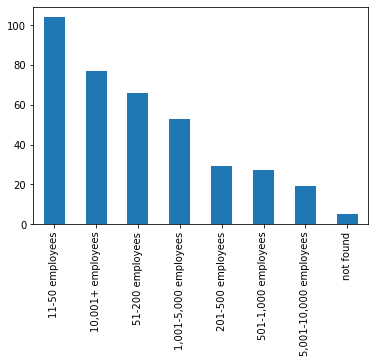

In [519]:
a = df_description['Company size'].value_counts()
a.plot.bar()
plt.show()

In [494]:
import matplotlib.pyplot as plt

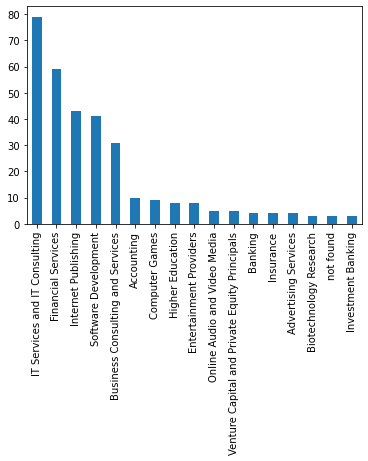

In [521]:
a = df_description['Industry'].value_counts()
b= a[a>2]
b.plot.bar(align="center")
#plt.xticks(rotation = 180) # Rotates X-Axis Ticks by 45-degrees
plt.show()

# NEXT STEP
Analysing with nlp the description of the company 

In [543]:
[value.lower() for value in df_description['Specialties']]


['cloud, mobile, cognitive, security, research, watson, analytics, consulting, commerce, experience design, internet of things, technology support, industry solutions, systems services, resiliency services, financing, and it infrastructure',
 'enterprise, software, applications, database, middleware, fusion, business intelligence, primavera, peoplesoft, epm, bea, hyperion, retek, utilities, on-demand, server & storage systems, bpm, solutions for communications industry, erp, crm, crm on demand, jde, and siebel',
 'management consulting, systems integration and technology, business process outsourcing, and application and infrastructure outsourcing',
 'business software, developer tools, home & educational software, tablets, search, advertising, servers, windows operating system, windows applications & platforms, smartphones, cloud computing, quantum computing, future of work, productivity, ai, artificial intelligence, machine learning, laptops, mixed reality, virtual reality, gaming, d